# Probit Example for Moment Sensitivity

This example is a replication of the probit model in [Honoré, Jørgensen & de Paula (2020)](https://papers.ssrn.com/abstract=3518640), Section 3.1.

Through this example, we will show you how to set up the `params`, how to use the`optimize` functions, and how to calculate the local `moment_sensitivity` measurements for your own model. 

In [189]:
import numpy as np
import pandas as pd
from scipy import stats
from estimagic.optimization.optimize import minimize
from estimagic.differentiation.differentiation import jacobian
from estimagic.moment_sensitivity import moment_sensitivity

In [190]:
import matplotlib.pyplot as plt
import seaborn as sns
from sestimagic.ensitivity_plot import moment_sensitivity_plot
sns.set(style="whitegrid")

## Input Data

First, we should create the index for `params`. Here, we only have one set of params, `beta`. 

In [3]:
params_index = [['beta'], ['intersection', 'x1', 'x2']]
params_index = pd.MultiIndex.from_product(params_index, names=['type', 'name'])
print(params_index)

MultiIndex([('beta', 'intersection'),
            ('beta',           'x1'),
            ('beta',           'x2')],
           names=['type', 'name'])


Now read the data.

In [4]:
y = pd.read_csv("moment_sensitivity_y.csv", header=None)
y.columns = ["y_probit"]

In [5]:
x = pd.read_csv("moment_sensitivity_x.csv", header=None)
x.columns = ["intertsection","x1","x2"]

Text(0.5, 1.0, 'Independent Variables')

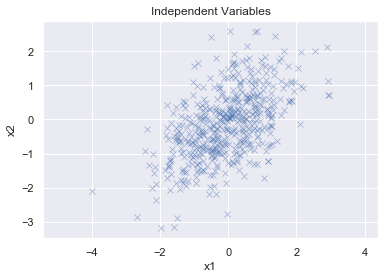

In [6]:
plt.clf()
plt.axis('equal')
sns.scatterplot(x="x1",
                y="x2",
                data=x,
                marker="x",
                alpha="0.5",).set_title("Independent Variables")

Text(0.5, 1.0, 'Dependent Variables')

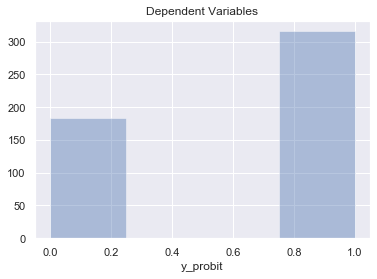

In [7]:
plt.clf()
sns.distplot(a=y["y_probit"],
             kde=False).set_title("Dependent Variables")

## Calculate the Moments

In [8]:
def calc_moments_value(params, x, y, estimate_y=True):
    """This is the func2 in sensitivity module.
    
    Args:
        params (pd.DataFrame): see :ref:`params`
        x (pd.DataFrame)
        y (pd.DataFrame)
        estimate_y (boolean): use estimated y_star
    
    Return:
        mom_value (pd.DataFrame): sample value of moments
    """
    
    if estimate_y == True:
        y_estimated = y_estimated = x.to_numpy() @ (params["value"].to_numpy())
    else:
        y_estimated = y.copy(deep=True)
    
    x_np = x.T.to_numpy()
    
    residual = y.T.to_numpy() - stats.norm.cdf(y_estimated)
    mom_value = []
    
    # loop through all x

    length = len(x_np)
    
    for i in range(length):
        for j in range(i,length):
            moment = residual * x_np[i] * x_np[j]
            mom_value.append(moment)
    
    mom_value = np.stack(mom_value, axis=1)[0]
    mom_value = pd.DataFrame(data=mom_value)
    
    return mom_value

In [10]:
def calc_moments_expectation(params, x, y, estimate_y=True):
    """This is the func1 in sensitivity module.
    
    Args:
        params (pd.DataFrame): see :ref:`params`
        x (pd.DataFrame)
        y (pd.DataFrame)
        estimate_y (boolean): use estimated y_star
    
    Return:
        moments (np.array): expectation of moments
    """
    
    mom_value = calc_moments_value(params, x, y, estimate_y)
    
    moments = mom_value.mean(axis=1)
    
    # do not use pd.DataFrame since jacobian: extrapolation=False
    # moments = pd.DataFrame(data=moments,
    #                        columns=["moments"])
    
    return moments

## Criterion Function & Estimation

This is the criterion function:

In [11]:
def criterion_func(params, x, y, weight_matrix):
    """
    Args:
        params (pd.DataFrame)
        x (pd.DataFrame)
        y (pd.DataFrame)
        weight_matrix (np.array)
    
    Return:
        criterion (float)
    """
    
    moments = calc_moments_expectation(params, x, y, estimate_y=True).to_numpy()

    criterion = moments.T @ weight_matrix @ moments
    criterion = criterion.item()

    return criterion

Give the initial arguments:

In [12]:
I_matrix = np.identity(6)

params_init = pd.DataFrame(data=[[0.], [0], [0]],
                           index=params_index,
                           columns=["value"])
params_init

value
type name               
beta intersection    0.0
     x1              0.0
     x2              0.0

Now, we can estimate the `params` using identity matrix as the weight matrix:

In [13]:
estimation = minimize(criterion = criterion_func,
                      params = params_init,
                      criterion_kwargs = {"x":x,
                                          "y":y,
                                          "weight_matrix":I_matrix},
                      algorithm = "scipy_L-BFGS-B")

In [14]:
params_estimated = pd.DataFrame(data=estimation[0]["x"],
                                index=params_index,
                                columns=["value"])
params_estimated

value
type name                  
beta intersection  0.612646
     x1            0.651558
     x2            0.574975

The true `beta`'s for this data are $1/\sqrt{3}\approx 0.57735$, so that looks ok for the small sample size.

## Sensitivity Measurements

Now, we can call the sensitivity function without specifying a weight matrix, in other words, using the optimal weight matrix.

In [92]:
sensitivity = moment_sensitivity(func1=calc_moments_expectation, 
                                 func2=calc_moments_value, 
                                 params=params_estimated,
                                 func1_kwargs={"x": x,
                                               "y": y},
                                 func2_kwargs={"x": x,
                                               "y": y},
                                 save_csv=False)

In [126]:
sensitivity

[                          0         1         2         3         4         5
 type name                                                                    
 beta intersection  4.488933  2.202800  2.869532  0.358412  1.562034  0.637375
      x1            0.856247  6.960227 -2.218059  1.374285 -2.160678 -0.087258
      x2            2.430105 -1.500825  7.776466 -0.994083  1.803429  0.208955,
                           0         1         2         3         4         5
 type name                                                                    
 beta intersection  1.207190  0.189113  0.304658  0.009399  0.051347  0.025318
      x1            0.029976  1.288557  0.124229  0.094310  0.067050  0.000324
      x2            0.237320  0.058888  1.500893  0.048502  0.045912  0.001825,
                           0         1         2         3         4         5
 type name                                                                    
 beta intersection  1.207190  0.189113  0.304658  

## Visualization

'Figures saved.'

<Figure size 432x288 with 0 Axes>

<Figure size 378x504 with 0 Axes>

<Figure size 378x504 with 0 Axes>

<Figure size 378x504 with 0 Axes>

<Figure size 378x504 with 0 Axes>

<Figure size 378x504 with 0 Axes>

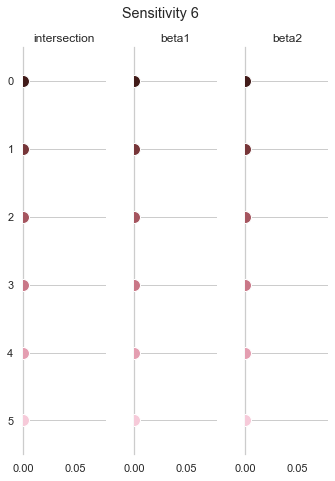

In [13]:
moment_sensitivity_plot(sensitivity)